# Basket Options

A basket (put or call) option is an option on a basket of securities, commodities, or currencies (it is similar to an option on index).

Who uses basket options?
* Multinational corporations that want to hedge against a number of FX risks.
* Investors who wish to have a broad exposure to (or hedge) particular portfolios, industry sectors, or countries.

Index options are an alternative to basket options, but if the index does not match the desired portfolio there will be significant tracking error risk that can cost more than the additional cost of the basket option. Another alternative is a collection of individual stock options, but this may be more expensive due to transaction costs and because the implied volatility of each option includes a large component of specific stock risk which may be diversified in a basket.

The discounted payoff function is given by:

$$
V_{\text{basket}} =
e^{-rT} \left( \sum_i^m x_i S_i(T) - K \right)^+
$$

where $S_i(t)$ is the asset value at time $t$ of asset $i$, $m$ is the number of assets in the basket, $x_i$, is the weight of asset $i$ in the basket (which does not change over time), $K$ is the strike price, $r$ is the risk-free rate, and $T$ is the time to maturity.

Let's assume we have a client that wants to protect their portfolio of tech stocks for the next year by purchasing an at-the-money basket put option on the five stocks in the portfolio (IBM, NFLX, MSFT, FB, and AAPL), where the stocks are equally-weighted. 

Let's, using Monte-Carlo, compute the price (along with the estimated error) of the basket option for the client. 

We assume that the risk-free rate is 2% and use the last year of daily prices to compute the correlation matrix.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

Let's generate correlated Brownian motion

In [2]:
def corr_brownian(mu, sigma, T, dt, S0, corr):
    n = int(T / dt) + 1
    Z = np.random.normal(size=(corr.shape[0], n, 5))
    Z_corr = np.einsum("ij, jkl -> ikl", np.linalg.cholesky(corr), Z)
    S = np.zeros((corr.shape[0], n, 5))
    S[:, 0, :] = S0.reshape(-1, 1)
    for i in range(1, n):
        S[:, i, :] = S[:, i - 1, :] * np.exp(
            (mu.reshape(-1, 1) - 0.5 * sigma.reshape(-1, 1) ** 2) * dt
            + sigma.reshape(-1, 1) * np.sqrt(dt) * Z_corr[:, i - 1, :]
        )
    return S

Testing it

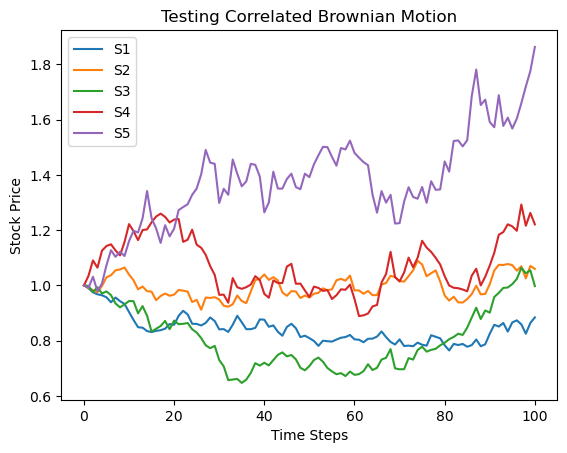

In [3]:
mu = np.array([0.05, 0.1, 0.15, 0.2, 0.25])
sigma = np.array([0.2, 0.25, 0.3, 0.35, 0.4])
T = 1.0
dt = 0.01
S0 = np.array([1.0, 1.0, 1.0, 1.0, 1.0])
corr = np.array(
    [
        [1.0, 0.5, 0.3, 0.2, 0.1],
        [0.5, 1.0, 0.5, 0.3, 0.2],
        [0.3, 0.5, 1.0, 0.5, 0.3],
        [0.2, 0.3, 0.5, 1.0, 0.5],
        [0.1, 0.2, 0.3, 0.5, 1.0],
    ]
)

S = corr_brownian(mu, sigma, T, dt, S0, corr)

plt.plot(S[0, :, 0])
plt.plot(S[1, :, 0])
plt.plot(S[2, :, 0])
plt.plot(S[3, :, 0])
plt.plot(S[4, :, 0])
plt.legend(["S1", "S2", "S3", "S4", "S5"])
plt.title("Testing Correlated Brownian Motion")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.show()

In [4]:
stocks = ["IBM", "NFLX", "MSFT", "AAPL", "META"]
weights = [0.25, 0.25, 0.25, 0.25, 0.25]
start_date = datetime.date(2022, 3, 5)
end_date = datetime.date(2023, 3, 5)
strike_price = None
risk_free_rate = 0.02
num_simulations = 10000

# prices of the stocks using yfinance
prices = yf.download(
    stocks, start=start_date - datetime.timedelta(days=365), end=start_date
)["Adj Close"]

last_price = prices.iloc[-1]
returns = prices.pct_change().dropna()
correlation_matrix = returns.corr()
drifts = returns.mean() * len(returns)
volatilities = returns.std() * np.sqrt(len(returns))

print("\nCorrelation Matrix")
print(correlation_matrix)
print("\nDrifts and Volatilities")
print(np.array(drifts))
print(np.array(volatilities))

[*********************100%%**********************]  5 of 5 completed

Correlation Matrix
          AAPL       IBM      META      MSFT      NFLX
AAPL  1.000000  0.124659  0.428870  0.699263  0.361198
IBM   0.124659  1.000000  0.057525  0.035345 -0.160987
META  0.428870  0.057525  1.000000  0.534275  0.437277
MSFT  0.699263  0.035345  0.534275  1.000000  0.447017
NFLX  0.361198 -0.160987  0.437277  0.447017  1.000000

Drifts and Volatilities
[ 0.33077031  0.14548014 -0.1872555   0.25826474 -0.27459323]
[0.24219112 0.21048039 0.40930979 0.22691955 0.3942563 ]


In [21]:
# Set the random seed for reproducibility
np.random.seed(42)

# Define the initial stock prices, weights, time horizon, time step, drifts, volatilities, correlation matrix, and number of simulations
S0 = np.array(last_price)  # Initial stock prices
w = np.ones_like(S0) / len(S0)  # Weights
T = 1  # Time horizon
dt = 1 / 252  # Time step
mu = np.array(drifts)  # Drifts
sigma = np.array(volatilities)  # Volatilities
corr = np.array(correlation_matrix)  # Correlation matrix
N = 10000  # Number of simulations

# Initialize the prices array with the initial stock prices
prices = np.zeros((N + 1, len(S0)))
prices[0] = S0

# Simulate the stock prices using correlated Brownian motion
for i in range(N):
    S = corr_brownian(mu, sigma, T, dt, S0, corr)
    prices[i + 1] = S[-1][-1]  # Store the final simulated prices

# Calculate the strike price, payoff, option price, and option error
strike_price = np.dot(S0, w)
payoff = np.maximum(strike_price - np.dot(prices[1:], w), 0)
option_price = np.exp(-0.02 * T) * np.mean(payoff)
option_err = np.std(payoff) / np.sqrt(N)

# Print the option price and error
print(f"Price of basket put option: {option_price:.2f} with error: {option_err:.2f}")

Price of basket put option: 3.21 with error: 0.10


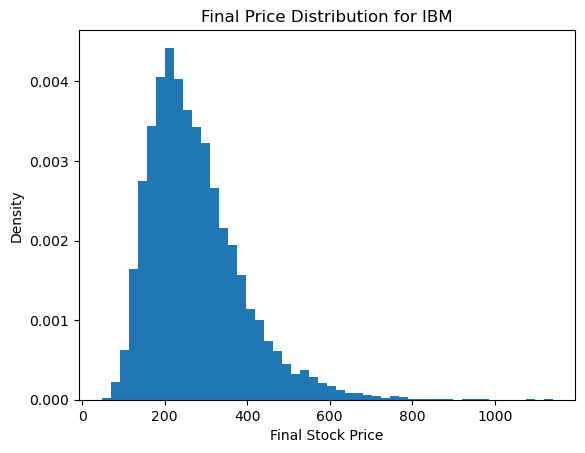

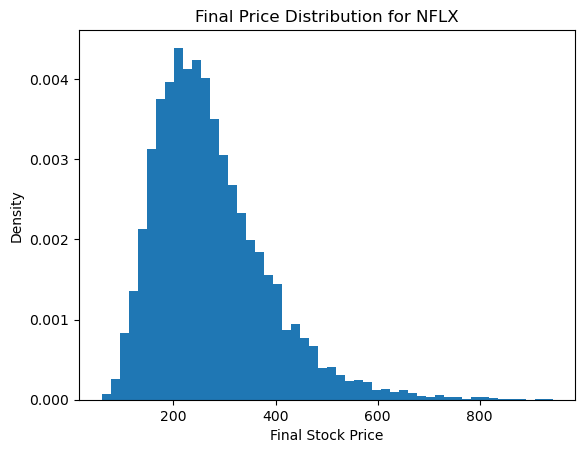

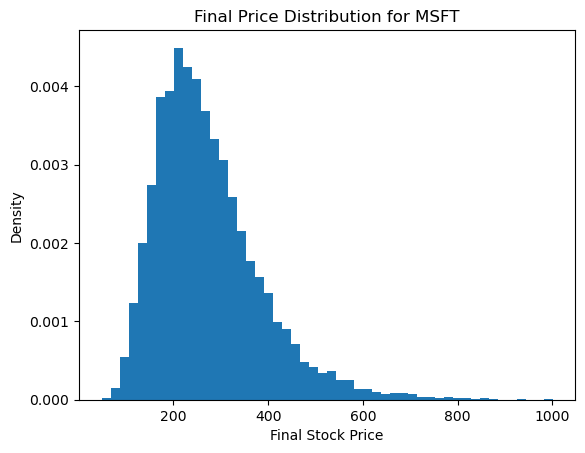

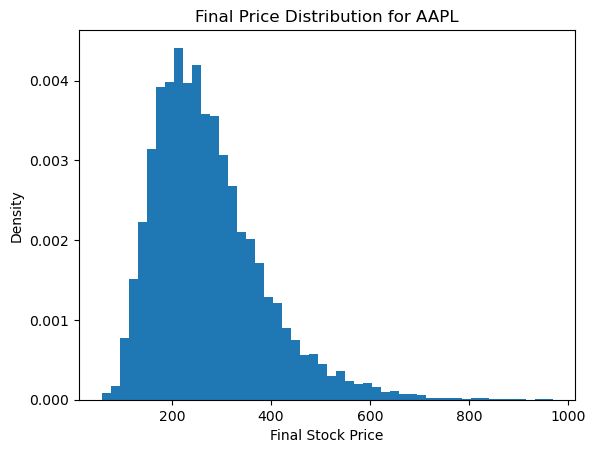

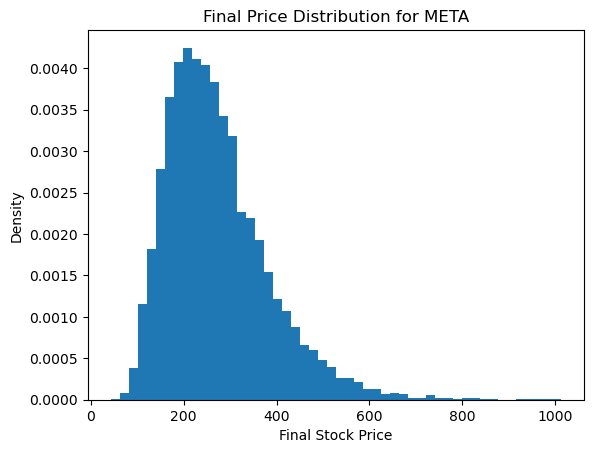

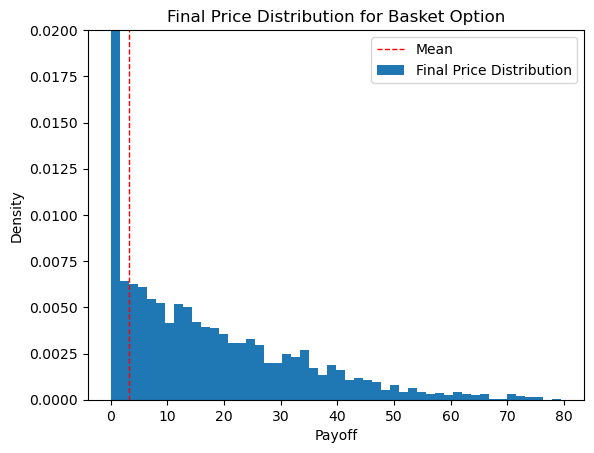

In [54]:
# plot final price distribution for each stock prices[:,i] and fit a log normal distribution to each stock price

for i in range(len(S0)):
    plt.hist(prices[:, i], bins=50, density=True)
    plt.title(f"Final Price Distribution for {stocks[i]}")
    plt.xlabel("Final Stock Price")
    plt.ylabel("Density")
    plt.show()

# make an interesting graph of the final price distribution for the basket option
plt.hist(payoff, bins=50, density=True)
# crop y axis to make the graph more readable
plt.ylim(0, 0.02)
#plot mean and standard deviation
plt.axvline(option_price, color='r', linestyle='dashed', linewidth=1)
plt.title("Final Price Distribution for Basket Option")
plt.xlabel("Payoff")
plt.ylabel("Density")
plt.legend(["Mean", "Final Price Distribution"])
plt.show()

